# Part 3

- Import du coefficient d'élasticité
- Génération du dataframe parent / enfant
- Génération du dataframe contenant l'ensemble des probabilités conditionnelles
- Génération du dataframe final : 500 individus par pays, dont la classe des parents dépend des probabilités conditionnelles obtenues


## Import librairies

In [1]:
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from descstats import MyPlot

pd.set_option('display.max_rows', None, 'display.max_columns', None)

Repository de mon module DescStats : https://github.com/nicodesh/DescStats

## Import data

In [2]:
with open("data/main_df.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    main_df = my_unpickler.load()
    
with open("data/overview.pkl", "rb") as f:
    my_unpickler = pickle.Unpickler(f)
    overview = my_unpickler.load()

## Import and merge IGM (Intergenerational mobility) coefficient

In [3]:
df = pd.read_csv("data/elasticity/country-group.csv", header=None)

df.rename(columns={0: 'country_full', 1:'igm_group'}, inplace=True)

def group_to_igm(group):
    """ Return an IGM value depending on the country group. """
    
    if (group == 1):# Nordic European countries and Canada
        return 0.2
    
    elif (group == 2):# Europe except nordic countries
        return 0.4
    
    elif (group == 3):# Australia / New Zealand / USA
        return 0.4
        
    elif (group == 4):# Asia
        return 0.5
    
    elif (group == 5):# Latin America / Africa
        return 0.66
    
df['igm_coeff'] = df['igm_group'].apply(group_to_igm)

main_df = main_df.merge(df, how='left', on='country_full')

main_df.head()

,country,year,quantile,nb_quantiles,income,gdpppp,country_full,population,gini,income_total,income_ratio,income_avg,igm_group,igm_coeff
0,ALB,2008,1,100,728.89795,7297.0,Albanie,2991651,0.32141,299482.9902,0.002434,2994.829902,1,0.2
1,ALB,2008,2,100,916.66235,7297.0,Albanie,2991651,0.32141,299482.9902,0.003061,2994.829902,1,0.2
2,ALB,2008,3,100,1010.91600,7297.0,Albanie,2991651,0.32141,299482.9902,0.003376,2994.829902,1,0.2
3,ALB,2008,4,100,1086.90780,7297.0,Albanie,2991651,0.32141,299482.9902,0.003629,2994.829902,1,0.2
4,ALB,2008,5,100,1132.69970,7297.0,Albanie,2991651,0.32141,299482.9902,0.003782,2994.829902,1,0.2


## Generate parent / child units

In [81]:
%%time

# Parent / Child generated dataframe
columns=['country', 'ln_yparent', 'epsilone', 'pj', 'ychild', 'cparent', 'cchild']
parent_child = pd.DataFrame(columns=columns)

# Number of generated units
n = 1000 * 100

# Compute ychild
def ychild(row):    
    return np.exp(row['pj'] * row['ln_yparent'] + row['epsilone'])

# Main loop
for the_country in main_df.country.drop_duplicates():

    # Get the IGM Coeff
    the_pj = main_df[main_df.country == the_country]['igm_coeff'].iloc[0]

    # Generate values
    s1 = pd.Series(np.random.normal(size=n))
    s1.name = "ln_yparent"
    s2 = pd.Series(np.random.normal(size=n))
    s2.name = "epsilone"
    # Concatenate
    temp_df = pd.concat([s1, s2], axis=1)
    temp_df['pj'] = the_pj
    temp_df['ychild'] = temp_df.apply(ychild, axis=1)

    # Compute cparent
    percentiles = np.argsort(np.argsort(temp_df['ln_yparent'])) * 100. / (len(temp_df['ln_yparent']) - 1)
    percentiles = np.ceil(percentiles).astype(int)
    temp_df['cparent'] = percentiles

    # Compute cchild
    percentiles = np.argsort(np.argsort(temp_df['ychild'])) * 100. / (len(temp_df['ychild']) - 1)
    percentiles = np.ceil(percentiles).astype(int)
    temp_df['cchild'] = percentiles

    # Add the country
    temp_df['country'] = the_country

    # Append to the main df
    parent_child = parent_child.append(temp_df, sort=False)

# Display the result
display(parent_child.shape)
display(parent_child.head())

(11400000, 7)

,country,ln_yparent,epsilone,pj,ychild,cparent,cchild
0,ALB,0.208198,0.054132,0.2,1.100507,59,54
1,ALB,0.309944,1.752853,0.2,6.140107,63,97
2,ALB,0.257302,2.528200,0.2,13.192656,61,100
3,ALB,1.286175,0.035333,0.2,1.339864,91,62
4,ALB,0.191726,0.606841,0.2,1.906342,58,74


CPU times: user 7min 3s, sys: 25.6 s, total: 7min 28s
Wall time: 7min 33s


## Save the dataframe

In [ ]:
with open("data/generated-units.pkl", "wb") as f:
    my_pickle = pickle.Pickler(f)
    my_pickle.dump(parent_child)

## Load the dataframe

In [4]:
with open("data/generated-units.pkl", "rb") as f:
    my_pickle = pickle.Unpickler(f)
    parent_child = my_pickle.load()

## Generate conditionnal probabilities dataframe

In [84]:
%%time

df_prob = {
    'country':[],
    'c_child':[],
    'c_parent':[],
    'prob':[]
}

for the_country in main_df['country'].drop_duplicates():
    
    data = parent_child[parent_child.country == the_country]
    len_total = len(data)

    for c_child in range(1,101):
        
        # Probabilité d'avoir cette classe d'enfant
        this_child = data[data['cchild'] == c_child]
        child_prob = len(this_child) / len_total

        for c_parent in range(1,101):
            
            # Probabilité d'avoir cette classe d'enfant ET cette classe de parent
            this_prob = len(this_child[this_child['cparent'] == c_parent]) / len_total

            # Probabilité d'avoir cette classe de parent sachant la classe de l'enfant
            cond_prob = this_prob / child_prob    

            # On rajoute la probabilité conditionnelle dans le dataframe
            df_prob['country'].append(the_country)
            df_prob['c_child'].append(c_child)
            df_prob['c_parent'].append(c_parent)
            df_prob['prob'].append(cond_prob)
            
df_prob = pd.DataFrame(df_prob)

display(df_prob.shape)
display(df_prob.head())

(1140000, 4)

,country,c_child,c_parent,prob
0,ALB,1,1,0.035035
1,ALB,1,2,0.027027
2,ALB,1,3,0.025025
3,ALB,1,4,0.018018
4,ALB,1,5,0.020020


CPU times: user 14min 37s, sys: 13.2 s, total: 14min 50s
Wall time: 15min 35s


## Save conditionnal probabilites

In [ ]:
with open("data/cond-prob.pkl", "wb") as f:
    my_pickle = pickle.Pickler(f)
    my_pickle.dump(df_prob)

## Load conditionnal probabilites

In [5]:
with open("data/cond-prob.pkl", "rb") as f:
    my_pickle = pickle.Unpickler(f)
    df_prob = my_pickle.load()

## Plot conditionnal probabilities for France

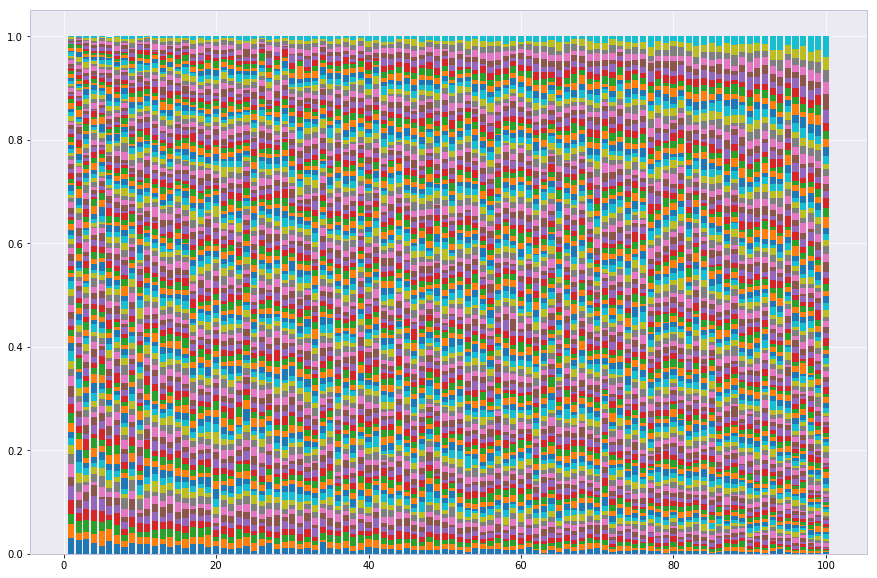

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
bottom = pd.Series(np.zeros(100))
df_fra = df_prob[df_prob.country == 'FRA']

for i in range(1,101):
    data = df_fra[df_fra.c_parent == i].sort_values(by='c_child')
    plt.bar(data['c_child'], data['prob'], bottom=bottom, zorder=2,label=i)
    bottom = bottom + data['prob'].reset_index(drop=True)
    
MyPlot.bg(ax)
MyPlot.border(ax)
plt.show()

## Create the final dataframe

In [51]:
%%time

final_df = {
    'country':[],
    'country_full':[],
    'quantile':[],
    'c_parent':[],
    'population':[],
    'gini':[],
    'income_avg':[],
    'income':[],
}

# Row
for i in range(0,len(main_df)):
    row = main_df.iloc[i]
    data = df_prob[df_prob['country'] == row['country']]
    data = data[data['c_child'] == row['quantile']]
    
    # Parent
    for j in range(1,101):
        
        # Number of parents
        n = int(round(data[data['c_parent'] == j]['prob'].iloc[0] * 500))
        
        # Copy the values n times
        final_df['country'].extend([row['country']]*n)
        final_df['country_full'].extend([row['country_full']]*n)
        final_df['quantile'].extend([row['quantile']]*n)
        final_df['income'].extend([row['income']]*n)
        final_df['population'].extend([row['population']]*n)
        final_df['gini'].extend([row['gini']]*n)
        final_df['income_avg'].extend([row['income_avg']]*n)
        final_df['c_parent'].extend([j]*n)
        
final_df = pd.DataFrame(final_df)
display(final_df.shape)
display(final_df.head())

(5664544, 8)

,country,country_full,quantile,c_parent,population,gini,income_avg,income
0,ALB,Albanie,1,1,2991651,0.32141,2994.829902,728.89795
1,ALB,Albanie,1,1,2991651,0.32141,2994.829902,728.89795
2,ALB,Albanie,1,1,2991651,0.32141,2994.829902,728.89795
3,ALB,Albanie,1,1,2991651,0.32141,2994.829902,728.89795
4,ALB,Albanie,1,1,2991651,0.32141,2994.829902,728.89795


CPU times: user 25min 39s, sys: 5.17 s, total: 25min 45s
Wall time: 25min 59s


## Save the final dataframe

In [83]:
with open("data/final_df.pkl", "wb") as f:
    my_pickle = pickle.Pickler(f)
    my_pickle.dump(final_df)